### OPTIMAL MARKET MAKING

In [5]:
# Primitive and third-party libraries
import os
import sys
import logging
import matplotlib
import asyncio
import nest_asyncio
import warnings
# Load simulator library
from backtest.detail.clock import Clock
from backtest.dtype.instrument import Instrument, Instruments
from backtest.schema.instrument_schema import instrument_schema
from backtest.orderbook.file_data_source import FileDataSource
# Load market making agent
from market_making.avellaneda.config import Config
from market_making.avellaneda.market_maker import AvellanedaMarketMaker

In [47]:
# Set jupyter environment
nest_asyncio.apply()
matplotlib.use('TkAgg')
%matplotlib inline
logging.getLogger().setLevel(logging.ERROR)

### 1. Motivation
We simulate trading agent's continuous bids and ask submission to a limit order book over a specific time horizon. The objective is to minimize the agent's inventory cost and maximizing wealth at the end of the trading window.

### 2. Model Setup

#### 2.1 The Mid-Price

Let $S_t$ be the stochastic process of the mid-price evolution[1] 

$\begin{array}{r,l}
&S_T = \sigma W_t \quad\quad (2.1)\\
\textit{where:}&\\
S_T &:\text{mid price}\\
W_t &:\text{Wiener process}\\
\sigma &:\text{volatility}\\
\end{array}$

Solve the integral to get the state value on each $\Delta t$

$\begin{array}{r,l}
\int_t^TdS_t &= \int_t^T \sigma W_tdt\\
S_T - S_t &= \sigma (W_T - W_t)\\
S_T &= S_t + \sigma (W_T - W_t)\\
\textit{where:}\quad\quad&\\
S_t &=\mu&\\
(W_T - W_t) &\approx N[0,T-t]&\\
S_t &\approx N[S_t, \sigma^2(T-t)]\\
\end{array}$

#####  2.1.1 The CARA Utility Function
The general formula of utility function with risk parameter.

$\begin{array}{r,l}
&U_{X_T} = -e^{-\lambda X_t}\\
\textit{where:}&\\
X_T &:\text{wealth value at terminal time $T$}\\
\lambda &:\text{risk aversion coefficient}\\
\end{array}$



Applying the stochastic process (2.1)

$\begin{array}{r,l}
&U_{X_T} = -e^{-\lambda (X_t + \sigma q_t S_t)}\\
\textit{where:}&\\
X_t &:\text{current wealth as the state value}\\
q_t &:\text{inventory size}\\
S_t &:\text{mid-price}\\
\end{array}$

##### 2.1.2 Objective Function
The market maker under consideration will continuously propose bid and ask prices denoted respectively $S_t^b$ and $S_t^a$ and will hence buy and sell shares according to the rate of arrival of market orders at the quoted prices. His inventory $q$, that is the (signed) quantity of shares he holds, is given by

$\begin{array}{c.l}
&q_t = N_t^b − N_t^a\\
\textit{where:}&\\
&N_t^b: \text{inventory bought}\\
&N_t^a: \text{inventory sold}\\
\end{array}$

The order processes $N^b$ and $N^a$ follows Avellaneda-Stoikov[1] order intensity depending on $s^b$ and $s^a$ and with $N^b$ and $N^a$ associated with the bid and ask spreads $\delta^b$ and $\delta^a$ such that:

$\begin{array}{c.l}
&\lambda^b(\delta^b) = Ae^{-k\delta^b}\\
&\lambda^b(\delta^b) = Ae^{-k(s - s^b)}\\
\textit{and}&\\
&\lambda^a(\delta^a) = Ae^{-k\delta^a}\\
&\lambda^a(\delta^a) = Ae^{-k(s^a-s)}\\
\textit{where:}&\\
k: &\text{positive constant reflecting liquidity}\\
A: &\text{positive constant reflecting liquidity}\\
\end{array}$

The closer $S_t^a$ or $S_t^b$ to the reference price the faster the order will be executed. $Q$ is a bound the market maker is allowed to have. The market maker has a time horizon T where P&L is as represented by the CARA utility function and optimizes as such:

The trading agent's wealth ($X$) will evolve according to the following dynamics:

$\begin{array}{c,l}
&dX_t=(S_t + \delta_t^a)dN_t^a - (S_t -\delta_t^b)dN_t^b\\
\text{where:}&\\
dX_t &: \text{change in wealth}\\ 
S_t &: \text{mid-price}\\
\delta_a &: \text{ask spread}\\
\delta_b &: \text{bid spread}\\
\end{array}$

The objective of the trading agent is to maximize the utility function:

$\begin{array}{r,l}
&u(x,s,q,t) = \underset{\delta_a, \delta_b}{\max} E_t\big[-e^{-\gamma(X_T + q_TS_T)}\big]\\
\end{array}$

##### 2.1.3 Value Function
The value function represents the minimum cost to go from state $X_t$ to $X_{t+\Delta t}$.

$\begin{array}{r,l}
&v(x,s,q,t) = E_t\big[-e^{-\gamma(x + qS_T)}\big]\\
\textit{where}: \quad&\\
v(x,s,q,t) &: \text{cost to go function}\\
\gamma &: \text{risk aversion coefficient}\\
\end{array}$

Solving the expectation, the value function leads to:

$\begin{array}{r,l}
&v(x,s,q,t) = -e^{-\lambda x}e^{-\lambda qs} e^{\frac{1}{2}\lambda^2 q^2 \sigma^2(T-t)} \quad\quad (2.2)\\
\end{array}$


### 2.2. Optimizing agent with finite horizon

The reservation bid price $r^b$ is given by implicit relation

$\begin{array}{l,r}
&v\big(x-r^b(s,q,t), s, q+1, t\big) = v(x,s,q,t) \quad\quad(2.3)
\end{array}$

and the reservation ask price $r^a$:

$\begin{array}{l,r}
&v\big(x+r^a(s,q,t), s, q-1, t\big) = v(x,s,q,t) \quad\quad(2.4)
\end{array}$

Using (2.2) (2.3) and (2.4) to calculate reservation bid and ask prices:

$\begin{array}{l,r}
&r^a(s,q,t) = s + (1-2q)\frac{\gamma \sigma^2(T-t)}{2}
\end{array}$

and

$\begin{array}{r,l}
&r^b(s,q,t) = s + (-1-2q)\frac{\gamma \sigma^2(T-t)}{2}
\end{array}$

The average of $r^a$ and $r^b$ is the reservation price or the indifference price.

$\begin{array}{r,l}
&r(s,q,t) = s - q \gamma \sigma^2 (T-t) \\
\textit{where:}&\\
r &: \text{reservation price}\\
q &: \text{inventory of stocks}\\
(q > 0) &: \text{agent is long position,  and $r < s$}\\
(q < 0) &: \text{agent is sell position and $r > s$}\\
\end{array}$

### 2.3 Optimizing agent with infinite time horizon

The closer the agent to $T$, the position is less risky. The infinite horizon form becomes:

\begin{align}
\bar{v}(x,s,q)= E\bigg[\int_0^\inf  -exp(-\omega t) exp(-\gamma(x + qS_t)) d_t\bigg]
\end{align}

The stationary reservation ask and bid prices, as in Defintion 1, is given by:

\begin{align}
\bar{r}^a(s, q) = s + \frac{1}{\gamma} \ln \bigg(1 +\frac{(1-2q)\gamma^2 \sigma^2}{2\omega - \gamma^2 q^2 \sigma^2} \bigg)
\end{align}

and

\begin{align}
\bar{r}^b(s, q) = s + \frac{1}{\gamma} \ln \bigg(-1 +\frac{(1-2q)\gamma^2 \sigma^2}{2\omega - \gamma^2 q^2 \sigma^2} \bigg)
\end{align}

where:

$\quad \omega > (1/2)\gamma^2 \sigma^2 q^2$

### 2.4 Limit Orders

Spreads:

$\begin{array}{r,l}
&\delta^b = s - p^b\\
\\
&\delta^a = p^a - a\\
\textit{where:}&\\
\delta^b &: \text{bid spread}\\
\delta^a &: \text{ask spread}\\
s &: \text{mid-price}\\
p^b &: \text{bid price}\\
p^a &: \text{ask price}\\
\end{array}$

When large market order to buy $Q$ stocks arrives, the $Q$ limit orders with lowest ask price will automatically execute. This causes temporary market impact, since transactions occur at a price higher than the mid-price.

$\begin{array}{r,l}
&\Delta_p = p^Q - s\\
\textit{where:}&\\
\Delta_p &: \text{market impact of trade size $Q$}\\
p^Q &: \text{limit order of size $Q$}\\
\end{array}$


The $\Delta p$ will impact the sell agents sell limit orders at a Poisson rage of $\lambda^a(\delta^a)$, a decreasing function of $\delta^a$. Likewise the sell limit orders will hit the agent's buy limit orders at the Poisson rate $\lambda^b(\delta^b)$, also a decreasing function of $\delta^b$. Intuitively, the further from the mid-price $s$ the quotes, the less often the agent will hit buy and sell orders.

The agent's wealth jumps stochastically each time orders are hit

$\begin{array}{r,l}
&dX_t = p^a dN_t^a - p^bdN_t^b\\
\textit{where:}&\\
N_t^b &: \text{inventory bought}\\
N_t^a &: \text{inventory sold}\\
\end{array}$

Both $N_t^b$ and $N_t^a$ are Poisson process events with intensities $\lambda^b$ and $\lambda^a$

The inventories held at time $t$ is

$\begin{array}{r,l}
&q_t = N_t^b - N_t^a\\
\textit{where:}&\\
N_t^b &: \text{inventory bought}\\
N_t^a &: \text{inventory sold}\\
\end{array}$

The objective of the trading agent is to maximize the utility function:

$\begin{array}{r,l}
&u(x,s,q,t) = \underset{\delta_a, \delta_b}{\max} E_t\big[-e^{-\gamma(X_T + q_TS_T)}\big]\\
\end{array}$

### 2.5 The Trading Intensity

The trading intensity is modeled using Poisson distribution. The limit order price is therefore a function of the poisson intensity $\lambda$ which is function of the distance of $\delta$ to the mid-price. In order to quantify we need to gather:

- A. Frequency of the market orders
- B. Distribution of the order sizes
- C. Impact of large market order

Aggregating these dataset, the $\lambda$ should decay as an exponential or power law function

We initially assumg a constant frequency $\Lambda$.

$\Lambda$ can be estimated by dividing the total volume traded over the day by the average size of orders on that day.

The distribution of the size of market orders follows a power law. The density of the order size is:

$\begin{array}{c,l}
&f^Q(x) \alpha x^{-1-\alpha} \quad\quad [2.5]\\
\textit{where:}&\\
\alpha &: 1.4 \approx 1.53
\end{array}$


The change in price $\Delta p$ following an order size of $Q$ is given by:

$\begin{align}
\quad \Delta p \alpha Q^\beta \quad\quad [2.6]
\end{align}$

where:
$\quad \beta$: 0.5 ~ 0.76

A better fit

$\begin{align}
\quad \Delta p \alpha \ln(Q) \quad\quad [2.7]
\end{align}$

Aggregating these information, we can derive the Poisson intensity at which the agent's orders are executed. The intensity will depend only on the distance fo the the quotes to the mid-price for the arrival of sell orders $\lambda^b \delta^b$, and $\lambda^a \delta^a$ for the arrival of buy orders.

Using (2.5) and (2.7) we can derive

$$\begin{align}
\lambda(\delta) &= \Lambda P(\Delta p > \delta)\\
\lambda(\delta) &= \Lambda P(\ln(Q) > K\delta) \\
\lambda(\delta) &= \Lambda P(Q > \exp(K \delta)) \\\
\lambda(\delta) &= \Lambda \int_{\exp(K\delta)}^\inf x^{-1\alpha}dx \\
\lambda^a(\delta^a) &= A e^{-k\delta^a} \\
\text{and}\\
\lambda^b(\delta^b) &= A e^{-k\delta^b} \\
\end{align}$$

where:

$\begin{align}
&\quad A: \frac{\Lambda}{\alpha} \text{, or baseline intensity}\\
&\quad k: \alpha K, \text{or liquidity parameter} \\
&\quad \Lambda: \text{constant frequency of buy or sell}; \approx \frac{\text{trade volume}}{(\text{order size})_{\mu}}\\
&\quad \alpha: \text{constant} \approx [1.4,1.53]\\
&\quad K: \text{market depth}
\end{align}$


### 3. Solution

#### 3.1 Solve optimal bid and ask prices

objective function

$\begin{array}{r,l}
&u(x,s,q,t) = \underset{\delta_a,\delta_b}{max} \mathbb{E}[\lambda(x_T + q_TS_T)]\\
\end{array}$

### 4. Simulation

Setup the market maker using a static file data source:

In [6]:
data_filename = "/tmp/btcusdt_20230908.dat.gz"
max_lines = 400_000 / 8  # load amount of tick data
tick_size = 100_000_000  # 100 ms time step

instrument: Instrument = instrument_schema["binance"]["perpetual"]["btc-usdt"]
instruments: Instruments = Instruments({instrument.trading_pair: instrument})
filenames = {instrument.trading_pair: data_filename}

data_source = FileDataSource(
    filenames=filenames,
    instruments=instruments,
    max_lines=max_lines,
    verbose=False)

# Extract timestamps
start_time = data_source.start_time()
end_time = data_source.end_time()

model = AvellanedaMarketMaker(
    config=Config,
    instruments=instruments, 
    data_source=data_source, 
    verbose=False)

# Set portfolio initial inventories
model.set_balance(instrument.base_asset, 0.05)
model.set_balance(instrument.quote_asset, 5000)

# Create clock to iterate time step
clock = Clock(
    tick_size=tick_size,
    start_time=start_time,
    end_time=end_time,
    verbose=False)

clock.add_iterator(data_source)

clock.add_iterator(model)

clock.backtest_til()

Loading BTC-USDT /tmp/btcusdt_20230908.dat.gz:   7%| | 1


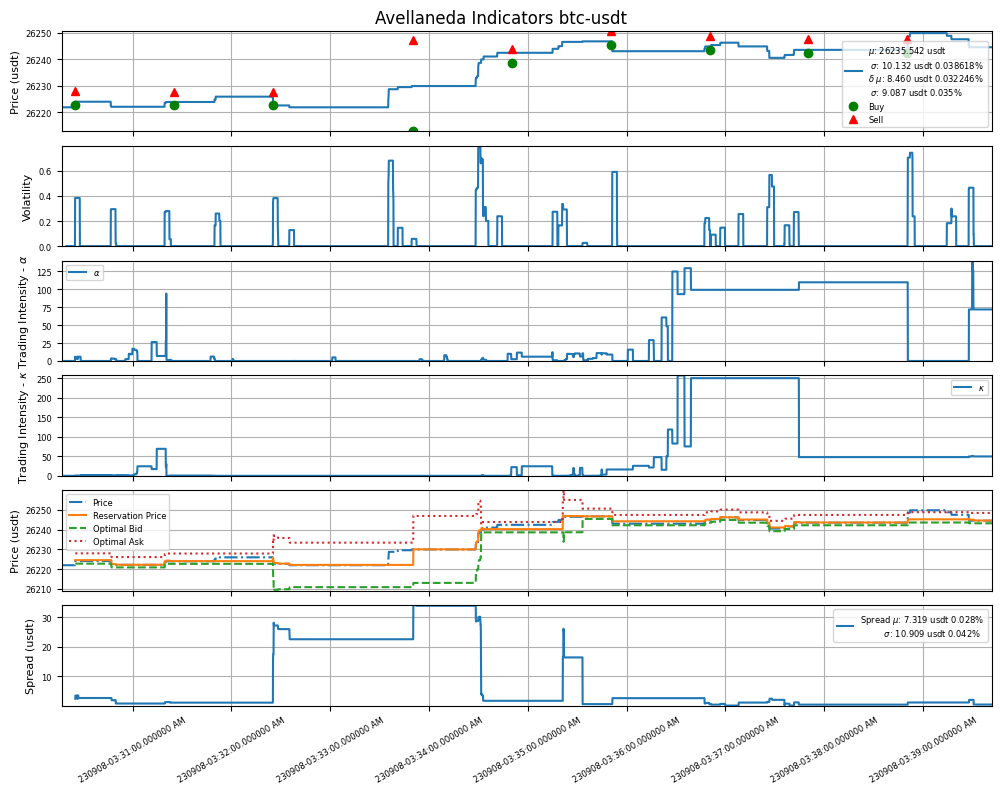

In [32]:
model.plot(filename=None)

### Reference

[1] Marco Avellaneda and Sasha Stoikov. High-frequency trading in a limit order book.
Quantitative Finance, 8(3):217–224, (2008)

[2] Guéant, O., Lehalle, CA. & Fernandez-Tapia, J. Dealing with the inventory risk: a solution to the market making problem. Math Finan Econ 7, 477–507 (2013)